In [1]:
print(__doc__)
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Automatically created module for IPython interactive environment


In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
data.target[[10, 50, 85]]

list(data.target_names)

['malignant', 'benign']

In [3]:
data.data.shape

(569, 30)

In [4]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [5]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 0.97


In [6]:
from sklearn.inspection import permutation_importance
result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                random_state=42)

In [7]:
perm_sorted_idx = result.importances_mean.argsort()
perm_sorted_idx

array([29, 25,  4, 19,  9, 11, 17, 28,  6, 22,  8, 23, 20, 18, 12, 16, 14,
        2,  3, 24, 15,  0, 26, 13,  5,  1, 10, 21,  7, 27])

In [8]:
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5
tree_indices

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
       22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5])

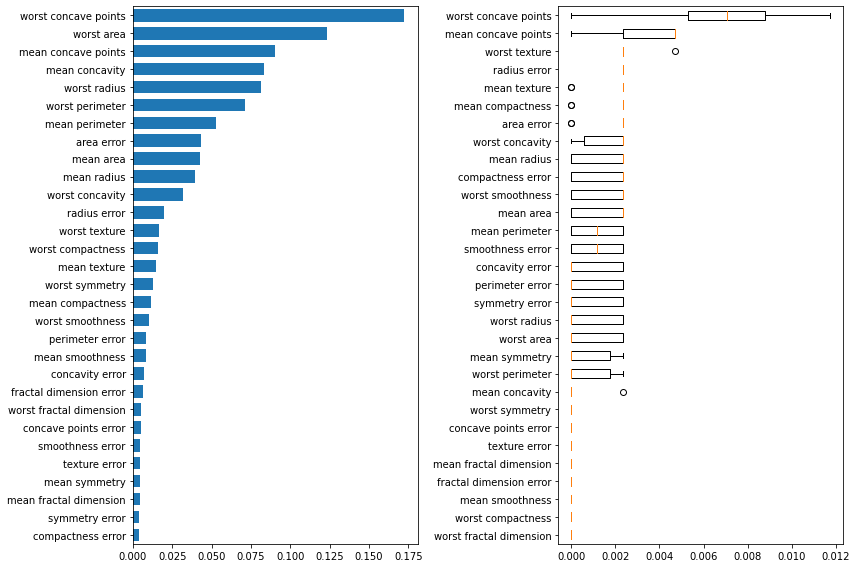

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
fig.tight_layout()

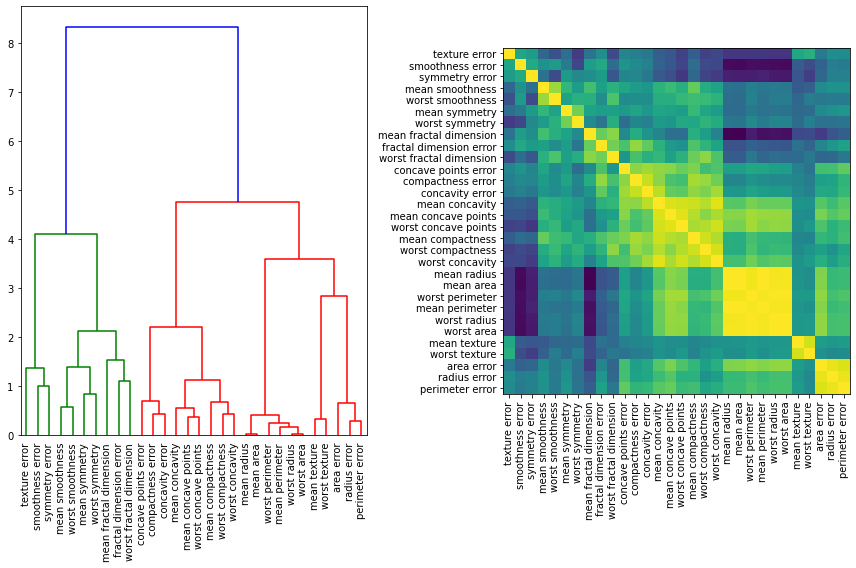

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()

In [11]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_ids

array([12, 13, 12, 12,  4, 11, 10, 10,  5,  8, 14,  3, 14, 14,  1,  9,  9,
        9,  2,  6, 12, 13, 12, 12,  4, 11, 11, 10,  5,  7], dtype=int32)

In [12]:
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

In [13]:
cluster_id_to_feature_ids

defaultdict(list,
            {12: [0, 2, 3, 20, 22, 23],
             13: [1, 21],
             4: [4, 24],
             11: [5, 25, 26],
             10: [6, 7, 27],
             5: [8, 28],
             8: [9],
             14: [10, 12, 13],
             3: [11],
             1: [14],
             9: [15, 16, 17],
             2: [18],
             6: [19],
             7: [29]})

In [14]:
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features

[0, 1, 4, 5, 6, 8, 9, 10, 11, 14, 15, 18, 19, 29]

In [15]:
X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

X_train_sel.shape, X_test_sel.shape

((426, 14), (143, 14))

In [16]:
clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 0.97
